In [1]:
from msresist.pre_processing import preprocessing
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting format
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:121: FutureWarning: The provided callable <function mean at 0x103ca8790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(X, values=values, index=indices, aggfunc=np.mean)
/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function mean at 0x103ca8790> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X = pd.pivot_table(triplicates, values=triplicates[data_headers].columns, index=merging_indices, aggfunc=func_tri)
/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function std at 0x103ca88b0> is currently using SeriesGroupBy.std. In a future version 

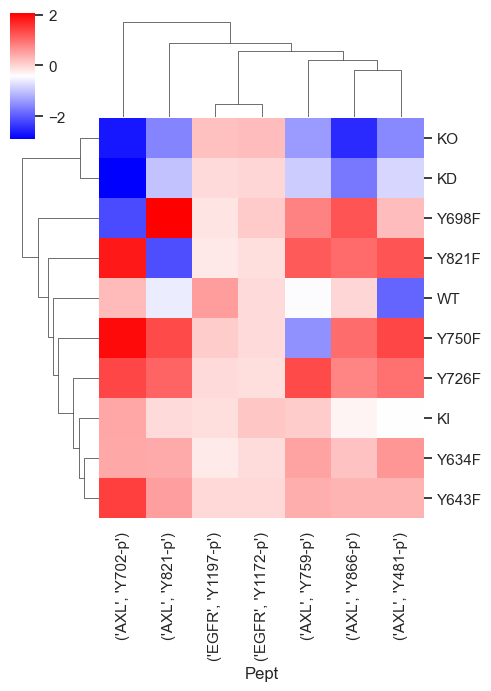

In [2]:
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True, mc_col=True)
X.columns = list(X.iloc[:, :7].columns) + ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F", "Y821F"]
df = X[(X["Gene"] == "EGFR") | (X["Gene"] == "AXL")]
df.insert(7, "Pept", list(zip(list(df["Gene"]), list(df["Position"]))))
sns.clustermap(df.iloc[:, 7:].set_index("Pept").T, cmap="bwr", robust=False, figsize=(5, 7))
# plt.savefig("egfr_axl_heatmap.svg")

In [3]:
from msresist.clustering import DDMC
from msresist.figures.common import import_phenotype_data, formatPhenotypesForModeling

# Import siganling data
X = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
centers = ddmc.transform()

/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:121: FutureWarning: The provided callable <function mean at 0x103ca8790> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(X, values=values, index=indices, aggfunc=np.mean)
/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function mean at 0x103ca8790> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X = pd.pivot_table(triplicates, values=triplicates[data_headers].columns, index=merging_indices, aggfunc=func_tri)
/Users/creixell/Documents/AXLomics/msresist/pre_processing.py:284: FutureWarning: The provided callable <function std at 0x103ca88b0> is currently using SeriesGroupBy.std. In a future version 

In [7]:
centers.shape

(10, 5)

In [8]:
X.insert(3, "Peptide", [g + " " + p for g, p in list(zip(list(X["Gene"]), list(X["Position"])))])

In [13]:
X[X["Gene"] == "AXL"].iloc[:, 8:]

,PC9 A,KO A,Kd A,KI A,M4 A,M5 A,M7 A,M10 A,M11 A,M15 A
545,-0.379962,-1.550019,-1.047904,0.037417,0.473327,0.476252,0.899552,1.388125,-1.481609,1.184822
546,0.045244,-2.642286,-1.863771,-0.347621,0.174237,0.411547,1.356708,0.827396,1.017384,1.021163
547,0.328338,-2.834358,-3.032106,0.397261,0.424876,1.556442,-2.051386,1.436222,1.952897,1.821814
548,-1.848437,-1.729465,-0.948922,-0.475617,0.591519,0.414745,0.336589,1.024967,1.382970,1.251650
549,-0.536236,-1.771713,-1.155004,-0.104836,0.411703,0.630248,2.169106,1.138084,1.347723,-2.129074


In [70]:
from scipy.stats import pearsonr, spearmanr

In [ ]:
# new vs old
# 1 is 4
# 2 is 5
# 3 is 3
# 4 is 1
# 5 is 2

In [105]:
axl = X[X["Gene"] == "AXL"]
pval = np.zeros((5, 5), dtype=float)
for ii in range(5):
    for jj in range(5):
        pval[ii, jj] = pearsonr(axl.iloc[ii, 8:].values, centers[:, jj])[1]

corr = pd.DataFrame(data=pval, index=axl.iloc[:, 4], columns=[1, 2, 3, 4, 5])

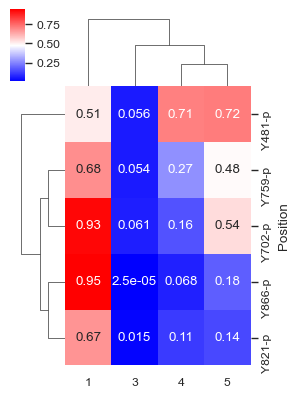

In [107]:
sns.clustermap(corr[[1, 3, 4, 5]], cmap="bwr", figsize=(3, 4), robust=True, mask=False, annot=True)
# plt.savefig("AXLpsites_vs_Clusters_Corr.svg")

In [80]:
# Import phenotypes
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")

In [108]:
pval_ph = np.zeros((4, 5), dtype=float)
for ii in range(4): #clusters
    for jj in range(5): #phenotypes
        pval_ph[ii, jj] = pearsonr(y.iloc[:, ii].values, centers[:, jj])[1]

corr_ph = pd.DataFrame(data=pval_ph, index=y.columns, columns=[1, 2, 3, 4, 5])

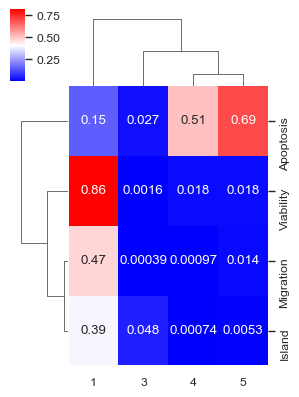

In [109]:
sns.clustermap(corr_ph[[1, 3, 4, 5]], cmap="bwr", figsize=(3, 4), robust=True, mask=False, annot=True)
# plt.savefig("Phenotypes_vs_Clusters_Corr.svg")

In [5]:
X.insert(6, "Cluster", ddmc.labels())
deg = X[["Gene", "Position", "Cluster"]]
deg["WT/KO"] = X["PC9 A"].values - X["KO A"].values
# deg = deg[deg["Cluster"] != 5]
deg.insert(3, "Peptide", [g + " " + p for g, p in list(zip(list(deg["Gene"]), list(deg["Position"])))])
deg = deg.sort_values(by="WT/KO", ascending=False)
deg.head()

/var/folders/0l/nldrkv114z3050ksk6zhq7bm0000gp/T/ipykernel_22043/2381711155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deg["WT/KO"] = X["PC9 A"].values - X["KO A"].values


,Gene,Position,Cluster,Peptide,WT/KO
473,SOS1,Y1196-p,3,SOS1 Y1196-p,3.624486
547,AXL,Y702-p,3,AXL Y702-p,3.162696
314,MAPK1,Y187-p,3,MAPK1 Y187-p,2.940818
319,MAPK3,Y204-p,3,MAPK3 Y204-p,2.933746
225,GAB1,Y406-p,5,GAB1 Y406-p,2.771247


In [31]:
deg.set_index("Peptide").loc[[
    "MET S988-p",
    "TCP1 S544-p",
    "CDK2 T158-p;T160-p",
    "GAB1 T316-p",
    "GAB2 T265-p"
]]

,Gene,Position,Cluster,WT/KO
Peptide,,,,
MET S988-p,MET,S988-p,4,-0.138624
TCP1 S544-p,TCP1,S544-p,4,1.349542
CDK2 T158-p;T160-p,CDK2,T158-p;T160-p,4,-0.994385
GAB1 T316-p,GAB1,T316-p,4,2.686679
GAB2 T265-p,GAB2,T265-p,4,1.926096


In [29]:
deg[deg["Peptide"].str.contains("GAB2")]

,Gene,Position,Cluster,Peptide,WT/KO
228,GAB2,T265-p,4,GAB2 T265-p,1.926096
227,GAB2,Y293-p,5,GAB2 Y293-p,1.575307
229,GAB2,Y266-p,5,GAB2 Y266-p,0.649180
230,GAB2,T294-p,4,GAB2 T294-p,0.400865


In [14]:
# 5 is 2
deg.set_index("Peptide").loc[[
    "EPHA2 Y594-p",
    "ERBB2 Y877-p",
    "GAB1 Y406-p",
    "GAB2 Y293-p",
    "DAPP1 Y139-p",
    "EPS8 Y602-p",
    "FRK Y132-p",
    "LYN Y397-p",
    "LCK Y192-p",
    "YES1 Y222-p",
    "ABL1 Y185-p",
    "ABI2 Y213-p",
    "CDK2 Y15-p"
]]

,Gene,Position,Cluster,WT/KO
Peptide,,,,
EPHA2 Y594-p,EPHA2,Y594-p,5,0.562521
ERBB2 Y877-p,ERBB2,Y877-p,5,1.109816
GAB1 Y406-p,GAB1,Y406-p,5,2.771247
GAB2 Y293-p,GAB2,Y293-p,5,1.575307
DAPP1 Y139-p,DAPP1,Y139-p,5,1.557306
EPS8 Y602-p,EPS8,Y602-p,5,0.770806
FRK Y132-p,FRK,Y132-p,5,0.441642
LYN Y397-p,LYN,Y397-p,5,0.694985
LCK Y192-p,LCK,Y192-p,5,0.353624


In [15]:
# 3 is 3
deg.set_index("Peptide").loc[[
    "SOS1 Y1196-p",
    "YES1 S195-p",
    "MAPK1 Y187-p",
    "MAPK3 Y204-p",
    "TNK2 Y859-p",
    "PRKCD Y313-p",
    "CDK1 Y15-p"
]]

,Gene,Position,Cluster,WT/KO
Peptide,,,,
SOS1 Y1196-p,SOS1,Y1196-p,3,3.624486
YES1 S195-p,YES1,S195-p,4,0.828987
MAPK1 Y187-p,MAPK1,Y187-p,3,2.940818
MAPK3 Y204-p,MAPK3,Y204-p,3,2.933746
TNK2 Y859-p,TNK2,Y859-p,3,2.218388
PRKCD Y313-p,PRKCD,Y313-p,3,0.821909
CDK1 Y15-p,CDK1,Y15-p,3,-2.684429


In [22]:
# 1 is 4
deg.set_index("Peptide").loc[[
    "EGFR Y1172-p",
    "ERBB3 Y1328-p",
    "MAPK10 Y223-p",
    "MAPK10 Y223-p;T221-p",
    "MAPK9 Y185-p;T183-p",
    "MAPK14 Y182-p"
]]

,Gene,Position,Cluster,WT/KO
Peptide,,,,
EGFR Y1172-p,EGFR,Y1172-p,1,-0.070417
ERBB3 Y1328-p,ERBB3,Y1328-p,1,-0.188773
MAPK10 Y223-p,MAPK10,Y223-p,1,-1.112191
MAPK10 Y223-p;T221-p,MAPK10,Y223-p;T221-p,1,-0.763061
MAPK9 Y185-p;T183-p,MAPK9,Y185-p;T183-p,1,-0.274732
MAPK14 Y182-p,MAPK14,Y182-p,1,-0.035857


In [ ]:
# new vs old
# 1 is 4
# 2 is 5
# 3 is 3
# 4 is 1
# 5 is 2

In [32]:
deg = deg.drop(["Position", "Peptide"], axis=1)
deg["WT/KO"] = np.abs(deg["WT/KO"])

In [33]:
dfs = []
for ii in set(deg["Cluster"]):
    cd = deg[deg["Cluster"] == ii].drop("Cluster", axis=1).groupby("Gene").sum()
    cd.insert(0, "Cluster", ii)
    dfs.append(cd)

In [34]:
dfs = pd.concat(dfs).sort_values(by="WT/KO", ascending=False)

In [35]:
dfs = dfs[dfs["Cluster"] != 2]
dfs.head(20)

,Cluster,WT/KO
Gene,,
AXL,3,8.374732
GAB1,5,7.361774
CBLB,3,5.379592
CTNND1,3,4.155357
ANXA2,3,3.659119
SOS1,3,3.624486
MAPK1,3,2.940818
MAPK3,3,2.933746
GAB1,3,2.809476


In [36]:
dfs.to_csv("Clusters_WTvsKO_pY.csv")

In [37]:
dfs.loc["TJP2"]

,Cluster,WT/KO
Gene,,
TJP2,5,2.129945
TJP2,3,1.470371


In [38]:
dfs.loc["CBLB"]

Cluster    3.000000
WT/KO      5.379592
Name: CBLB, dtype: float64

In [39]:
dfs.loc["MAPK1"]

Cluster    3.000000
WT/KO      2.940818
Name: MAPK1, dtype: float64

In [41]:
dfs.describe()

,Cluster,WT/KO
count,363.000000,363.000000
mean,3.385675,0.718486
std,1.494008,0.891342
min,1.000000,0.000549
25%,3.000000,0.217034
50%,3.000000,0.442803
75%,5.000000,0.905096
max,5.000000,8.374732
